# Face synthesis with StyleGAN v1

Tom Hatton | 18.12.2020

## Disclaimer
This demo notebook aims to provide a simple look into [nvidia's official Tensorflow implementation](https://github.com/NVlabs/stylegan) of the first version of StyleGAN and is based on the oroginal implementation and on adjusted notebook snippets from [Jeff Heaton](https://github.com/jeffheaton/t81_558_deep_learning/blob/master/t81_558_class_07_3_style_gan.ipynb). Although this notebook uses a pretrained model, the implementation requires the installation of `tensorflow-gpu==1.15`. From personal experience, the installation of Tensorflow's GPU version can be a struggle itself sometimes. In case of any problems, feel free to contact me and I will try my best to get the notebook running with you. If you have no GPU that supports `tensorflow-gpu` you can use Google Colab which offers free GPU usage. I will try to upload an adjusted version of this notebook which you can run on Google Colab in time!

Also note, that this implementation requires an older version of tensorflow (namely 1.15). This leads to a few warning messages of depracted functions. You can savely ignore them as of now.

## Setup

### Venv creation
To ensure you have all the right packages, create the virtual environment with the provided `environment.yml` file. To do this, enter the following lines in your console from the directory in which your .yml file is located (assuming you are using conda environments).

`conda create -n stylegan -f environment.yml`

Upon creation, activate your new virtual environment with 

`conda activate stylegan`

then start the jupyter notebook from within the environment with

`jupyter notebook`

### Getting the code

NVIDIA have provided their full source code on github which we will clone into our current directory in the first step.

In [ ]:
!git clone https://github.com/NVlabs/stylegan.git

Next up, we ensure that we can import the just downloaded repository simply as a package with the following command. Subsequently, we import the just downloaded files together with further required packages.

In [4]:
# Prepare import of stylegan package
import sys
sys.path.insert(0, "stylegan")

# Further imports
import os
import pickle
import PIL.Image
import dnnlib
import dnnlib.tflib as tflib
import config
import matplotlib.pyplot as plt
import numpy as np

### Downloading the pretrained model
We wil use a pre-trained model, provided by NVIDIA. The model was trained on the Flickr-Faces-HQ dataset at 1024x1024. Since the access to the original drive is sometimes limited through quota restrictions, we provide the model on _myShare_ [here](https://myshare.uni-osnabrueck.de/f/148ad26e871243cda4d2/). If _myShare_ does not work, [here](https://drive.google.com/drive/folders/1MASQyN5m0voPcx7-9K0r5gObhvvPups7) is the original drive.

Please download the model called `karras2019stylegan-ffhq-1024x1024.pkl` and store it in the same directory of this notebook.
You can also try out the network which was trained on celebrity faces in the CELEB-A-HQ dataset, called `karras2019stylegan-celebahq-1024x1024.pkl`, which you can download [here](https://myshare.uni-osnabrueck.de/f/52b1da1fbf044834bfa1/).

### On the datasets used
We would have liked to show you the data and how to download them, but due to the amount of both datasets (CELEB-A-HQ $\approx$ 30GB; FFHQ $\approx$ 90GB) we decided not to. However, if you want to download them, they are publicly available [here (CELEB-A-HQ)](https://github.com/tkarras/progressive_growing_of_gans) and [here (FFHQ)](https://github.com/NVlabs/ffhq-dataset). Furthermore, the CELEB-A (not HQ) dataset is included in `tensorflow_datasets` library and can be accessed via
```
import tensorflow_datasets as tfds

ds = tfds.load('celeba')
```
This, however, requires `tensorflow>=2.0`, which is incompatible with this demo. 

### Helper functions
The functions below allow for the random generation of latent vectors of a particular size, given a random seed and the generation of images given their latent vectors and the networks generator part. 

In [20]:
def expand_seed(seeds, vector_size):
    """
    This function takes a range of seeds, from each of which it generates a latent vector of the respective size 
    (512 in our case) and returns them as an array
    """
    result = []

    for seed in seeds:
        rnd = np.random.RandomState(seed)
        result.append( rnd.randn(1, vector_size) ) 

    return np.asarray(result)

def generate_images(Gs, seeds):
    """
    This function takes the network's Generator Gs and some seeds and generates an image from each latent vector and saves them to 
    the 'results' directory.
    """
    # Some sort of necessary output transform configuration
    fmt = dict(func=tflib.convert_images_to_uint8, nchw_to_nhwc=True)
    
    # For each seed, generate the respective image
    for seed_idx, seed in enumerate(seeds):
        print('Generating image for seed %d/%d ...' % (seed_idx, len(seeds)))
        images = Gs.run(seed,  None, truncation_psi=0.7, randomize_noise=True, output_transform=fmt)
        
        # Save images
        os.makedirs(config.result_dir, exist_ok=True)
        path = os.path.join(config.result_dir, f"image{seed_idx}.png")
        PIL.Image.fromarray(images[0], 'RGB').save(path)
        
    print("Generation complete!")

### Generating Images

In order to generate images we first have to initialize the Tensorflow session.

We then load the model from the previously downloaded `karras2019stylegan-celebahq-1024x1024.pkl` file, which gives us upon unpickling the models generator and discriminator networks. It is the Generator part `Gs` which we will need to generate new images. 

To generate images with the `Gs`, we need to provide a vector of size 512. We can to this by using the `expand_seed()` function. Provide this function with a list of integers (`seeds`) to get `len(seeds)` * 512 latent vectors. We encourage you to play around with some values. Note, that neighbouring values like 5 and 6 create completely different images and do not need to look similar (they very rarely do).

In [39]:
# Inititialize Tensorflow
tflib.init_tf()

#Load the network. Choose your network here.
with open('karras2019stylegan-ffhq-1024x1024.pkl', 'rb') as f:
#with open('karras2019stylegan-celebahq-1024x1024.pkl', 'rb') as f:

        _G, _D, Gs = pickle.load(f)
        # _G = Instantaneous snapshot of the generator. Mainly useful for resuming a previous training run.
        # _D = Instantaneous snapshot of the discriminator. Mainly useful for resuming a previous training run.
        # Gs = Long-term average of the generator. Yields higher-quality results than the instantaneous snapshot.

# Get the vector size from the generator's input shape.
vector_size = vector_size = Gs.input_shape[1:][0]

# Choose some seeds. Play around with them.
# Keep in mind, the images from two consecutive seeds can be totally different.
seeds = expand_seed(range(6000,6010), vector_size)

# Generate the images from the seeds
generate_images(Gs, seeds)

Generating image for seed 0/10 ...
Generating image for seed 1/10 ...
Generating image for seed 2/10 ...
Generating image for seed 3/10 ...
Generating image for seed 4/10 ...
Generating image for seed 5/10 ...
Generating image for seed 6/10 ...
Generating image for seed 7/10 ...
Generating image for seed 8/10 ...
Generating image for seed 9/10 ...
Generation complete!


### Inspecting the result

In the code's root directory there has now been a `results/` directory created, which contains your just generated faces. Check them out! 

## Exploring the latent vector space
Since we are walking in vector space we can take a look at the vectors from two images and interpolate between them to get some amazing _morphing_ results. In the cell below you can choose 2 seeds, `seed1` and `seed2` which you want to interpolate between.

Then, choose how many faces you want inbetween those to by setting the `STEPS` value. We chose `10` here for the inline display of the results in the second cell below. But you can increase the stepsize and view the results in full resolution in your explorer, too.

In [46]:
# e.g 400,602
seed1 = 4000 
seed2 = 3

seeds = expand_seed([seed1,seed2], vector_size)

# Take the difference between to vectors and divide it by the number of steps and gradually 
# add a part of the difference to the inital vector until reaching the vector of the second seed
STEPS = 30
diff = seeds[1] - seeds[0]
step = diff / STEPS
current = seeds[0].copy()

seeds2 = []
for i in range(STEPS):
    seeds2.append(current)
    current = current + step
    
generate_images(Gs, seeds2)



Generating image for seed 0/30 ...
Generating image for seed 1/30 ...
Generating image for seed 2/30 ...
Generating image for seed 3/30 ...
Generating image for seed 4/30 ...
Generating image for seed 5/30 ...
Generating image for seed 6/30 ...
Generating image for seed 7/30 ...
Generating image for seed 8/30 ...
Generating image for seed 9/30 ...
Generating image for seed 10/30 ...
Generating image for seed 11/30 ...
Generating image for seed 12/30 ...
Generating image for seed 13/30 ...
Generating image for seed 14/30 ...
Generating image for seed 15/30 ...
Generating image for seed 16/30 ...
Generating image for seed 17/30 ...
Generating image for seed 18/30 ...
Generating image for seed 19/30 ...
Generating image for seed 20/30 ...
Generating image for seed 21/30 ...
Generating image for seed 22/30 ...
Generating image for seed 23/30 ...
Generating image for seed 24/30 ...
Generating image for seed 25/30 ...
Generating image for seed 26/30 ...
Generating image for seed 27/30 ...
Ge

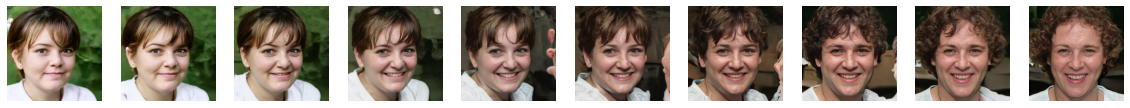

In [45]:
results_images = []

listing = os.listdir(config.result_dir)

for pic in listing:
    with open(os.path.join(config.result_dir, pic), 'rb') as f:
        pil_image = PIL.Image.open(f)
        results_images.append((np.asarray(pil_image)))
        
plt.figure(figsize=(20,30))

for i, image in enumerate(results_images):
    plt.subplot(1, len(results_images), i + 1)
    plt.axis('off')
    plt.imshow(image)

## Bonus

Nvidia also provided other pretrained networks, which have been trained on datasets other than faces, such as bedrooms and cats. Feel free to download them [here](https://drive.google.com/drive/folders/1MASQyN5m0voPcx7-9K0r5gObhvvPups7), load the new model just like you did above and generate images.

You can also download video software such as `ffmpeg` and concatenate multiple images from for interpolation experiment into a video to get a morph video, to get the _real_ morphing experience.